In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import seaborn as sns

from statannot import add_stat_annotation
from sklearn import metrics

import itertools

import scipy.stats as stats

from grs_pca import perform_grs_pca

/slade/home/pl450/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
np.__version__

'1.24.3'

In [3]:
from survival_analysis.utilities_mod import * 
from survival_analysis.stratifiedKM_plot import * 

import survival_analysis.grsplot as grsplot

In [4]:
import importlib

In [5]:
prefix = '/slade/home/pl450/Uveitis/GRS/python_analysis/'
data = (pd
        .read_csv(prefix + 'allGRS_forROCAUC_220524.tsv',
                  sep='\t', low_memory=False)
        .dropna(subset=['Sex']))

In [6]:
data = pd.get_dummies(data, columns = ['Sex'], drop_first=False)
data.drop(labels='Sex_Male', axis=1, inplace=True)

In [7]:
importlib.reload(grsplot)

<module 'survival_analysis.grsplot' from '/slade/home/pl450/Uveitis/GRS/python_analysis/survival_analysis/grsplot.py'>

In [19]:
def create_multiple_condition_subplots(data, pairs, uveitis_col, save_label='unnamed.svg',
                                      figsize= (9, 18), n_rows = 4, n_cols = 2):
    """
    Create subplots for genetic risk score distributions for multiple disease conditions.

    Parameters:
    data (pd.DataFrame): The dataset containing the data.
    pairs (list of tuples): List of tuples, where each tuple contains the disease column name and the GRS column name.
    uveitis_col (str): The uveitis status column in the data.
    save_label (str): Filename under which to save the figure.
    """
    # Determine the number of rows/columns based on the number of pairs
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # Loop over the conditions and their respective GRS columns
    for idx, (disease_col, grs_col) in enumerate(pairs):
        ax = axes[idx // n_cols, idx % n_cols]  # Determine the position of the current subplot

        # Define colors for plotting
        colors = {
            'Controls': 'gray',
            f'{disease_col.replace("_any", "")} only': 'green',
            'Uve': 'blue',
            f'{disease_col.replace("_any", "")}-Uve': 'orangered'
        }

        # Plot genetic risk scores distribution
        grsplot.plot_grs(data, disease_col, grs_col, uveitis_col, ax, colors=colors)

        # Set title for each subplot
        ax.set_title(f'{disease_col.replace("_any", "")}-GRS Distribution')
        ax.set_xlabel(f'{disease_col.replace("_any", "-GRS")}')
        
        if idx == 0 or (idx//n_cols)==0:
            ax.set_ylabel('Density')
        else:
            ax.set_ylabel('')

    # Enhance layout and display the plot
    plt.tight_layout(pad=1)
    plt.savefig(save_label)
    plt.show()

In [11]:
grs_list = ['AS_GRS', 'IBD_GRS','IBD_GRS', 'Psoriasis_GRS' ,
                'SLE_GRS', 'MS_GRS','RhA_GRS', 'Sarcoid_GRS']
disease_list = ['AS', 'Crohns', 'UC', 'Psoriasis',
                    'SLE', "MS", "RA", "Sarcoid"]
disease_list = [i+"_any" for i in disease_list]

pairs = list(zip(disease_list, grs_list))

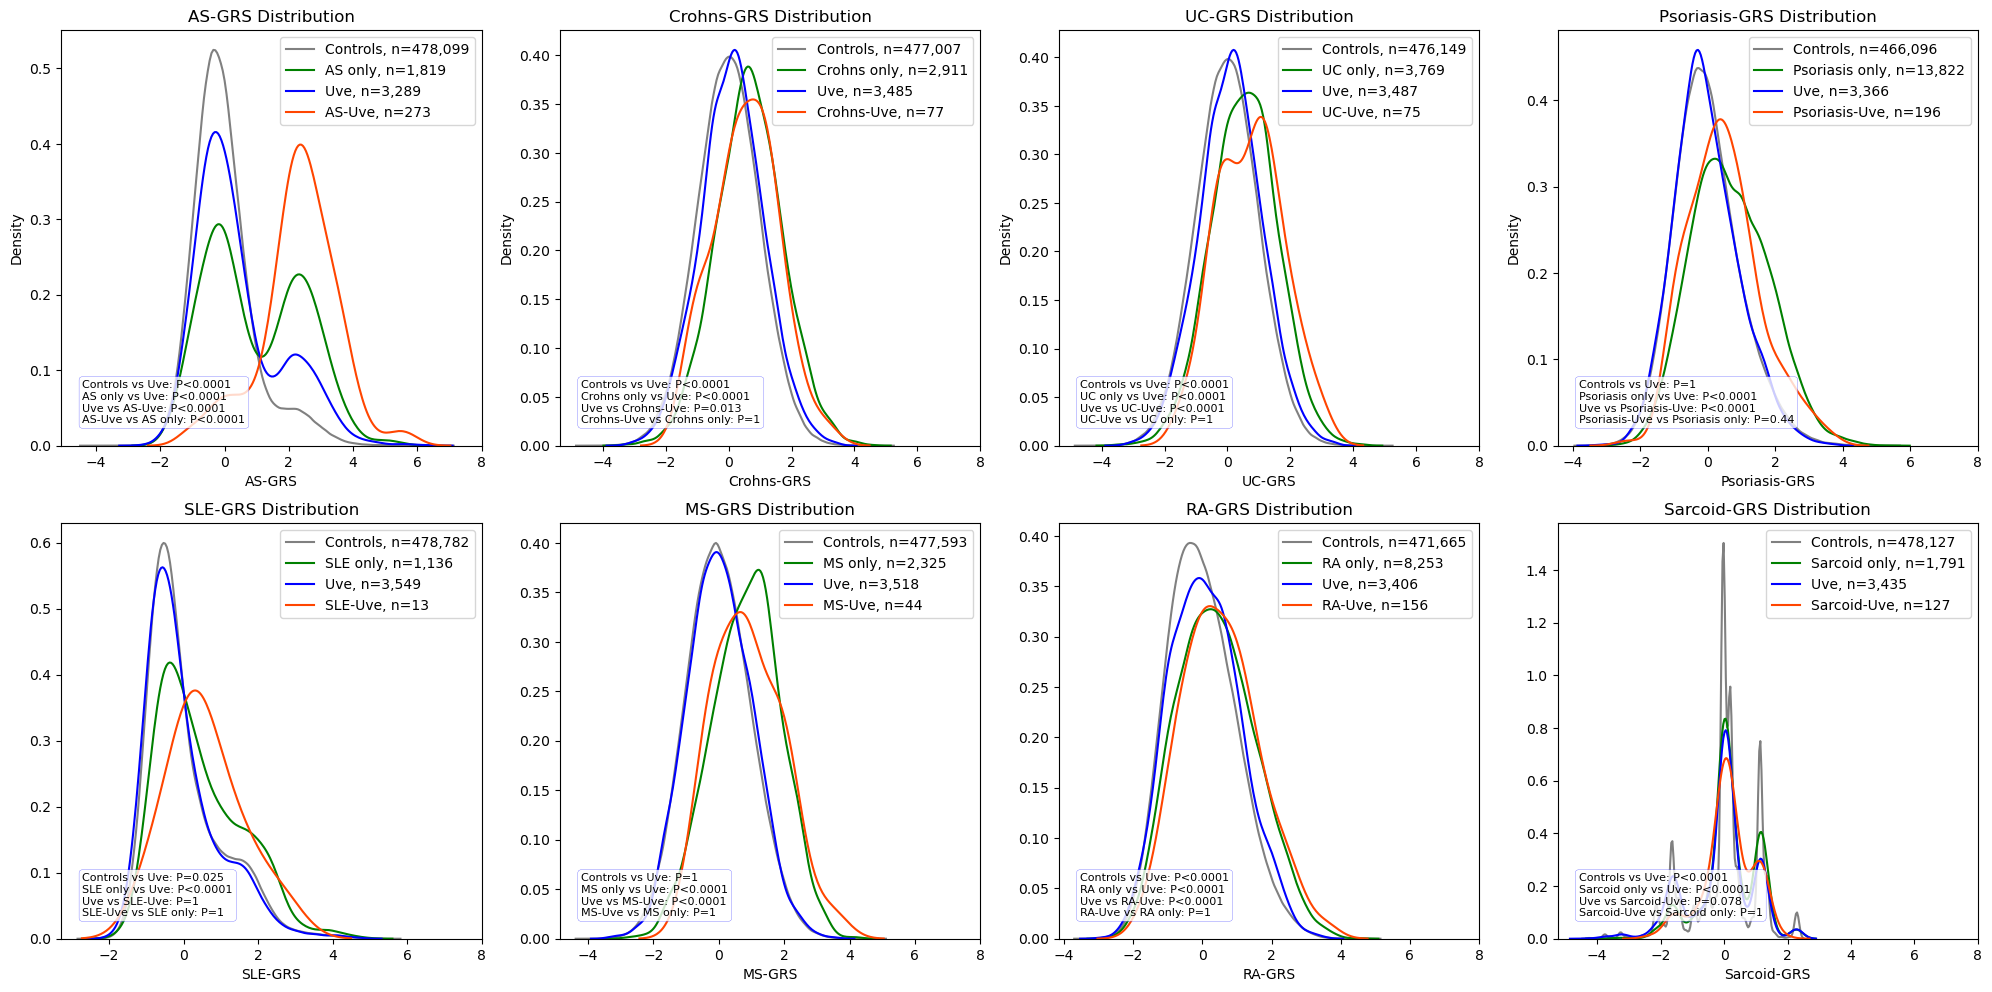

In [21]:
create_multiple_condition_subplots(data, pairs, 'uve_any',
                                   save_label='Eight_hists_pptx_180824.svg',
                                   n_rows=2, n_cols=4, figsize=(20,10))

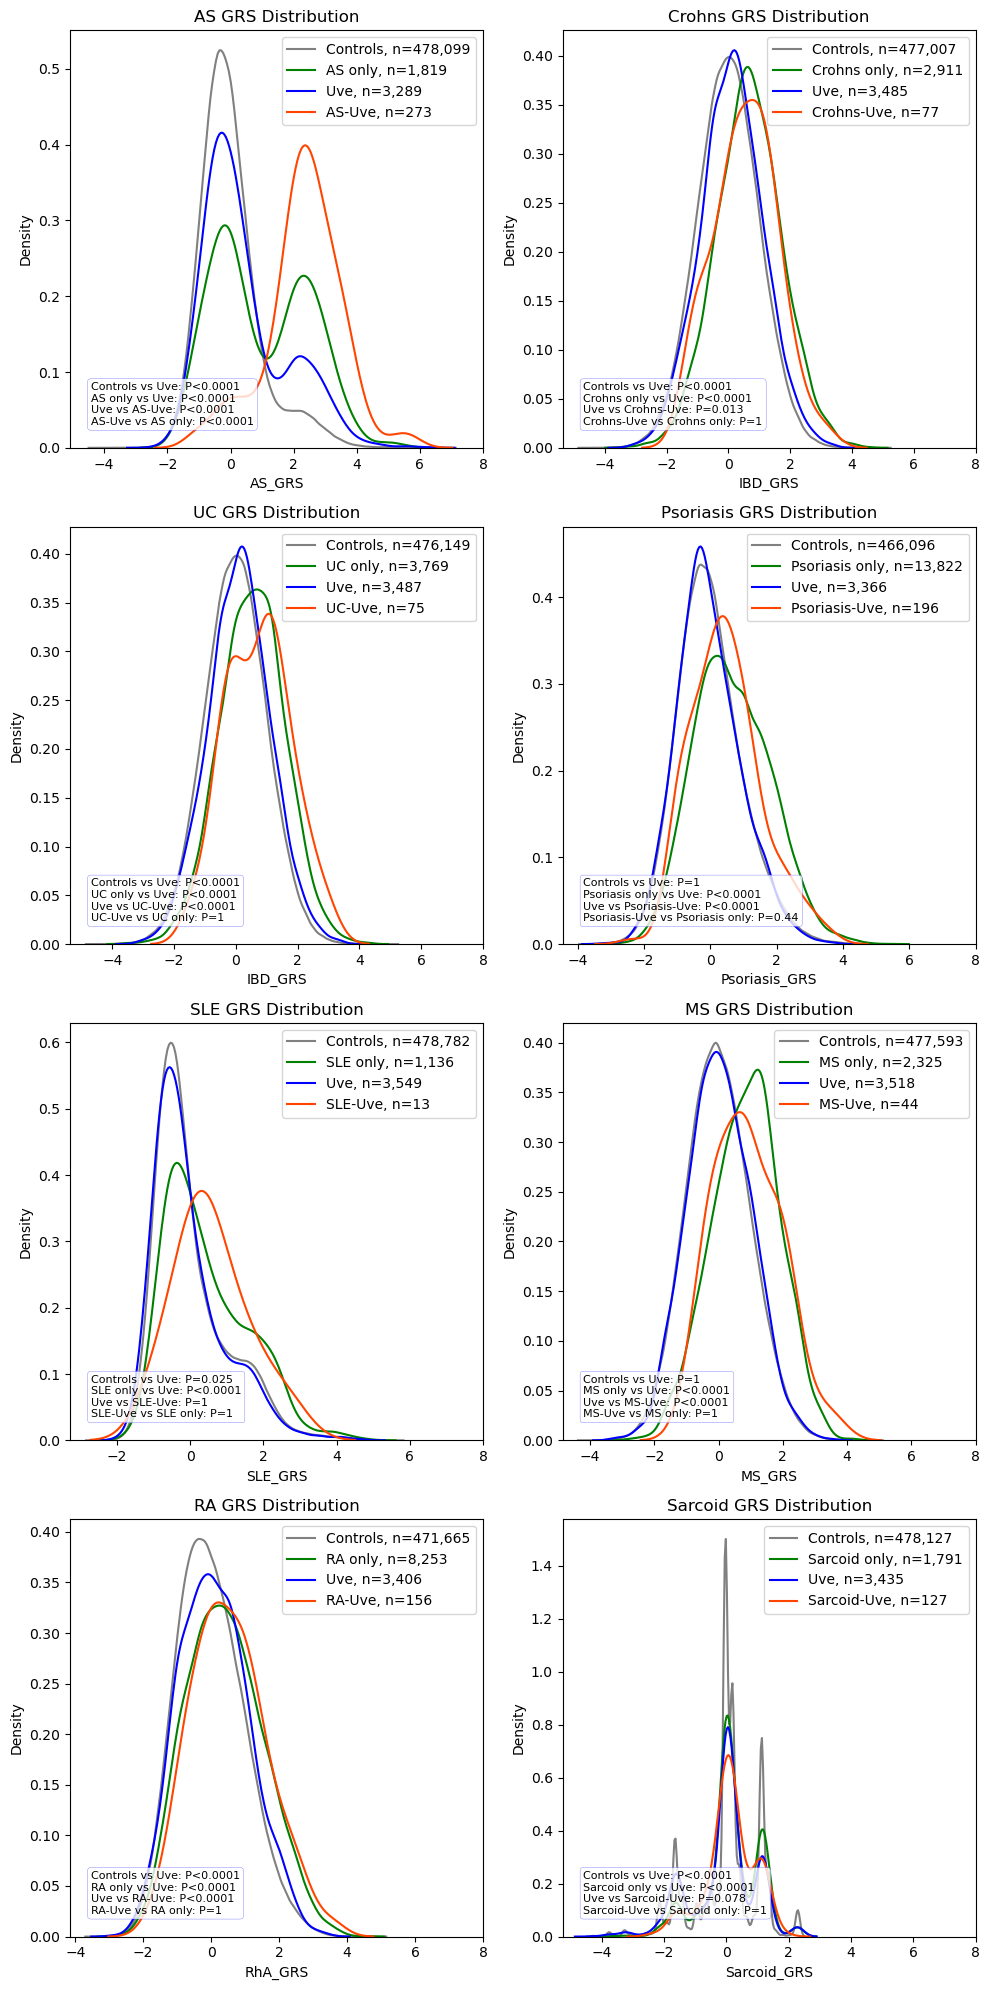

In [44]:
create_multiple_condition_subplots(data, pairs, 'uve_any',
                                   save_label='Eight_hists_080824.svg',
                                   n_rows=4, n_cols=2, figsize=(10,20))

In [21]:
def plot_grs_correlation_heatmap(data, grs_list, method='pearson', uveitis=False,
                                 filter_col='uve_any', additional_filter=None):
    """
    Create a heatmap of correlations between multiple Genetic Risk Scores (GRS) with Bonferroni-adjusted p-values.

    Parameters:
    data (pd.DataFrame): DataFrame containing the GRS data.
    grs_list (list): List of column names for the GRS scores.
    method (str): Correlation method ('pearson', 'spearman', or 'kendall'). Default is 'pearson'.
    uveitis (bool): Whether to filter data for uveitis cases. Default is False.
    filter_col (str): Column name for the uveitis filter. Default is 'uve_any'.
    additional_filter (dict): Additional filter to apply, specified as a dictionary with column names as keys and filter values as values.

    Returns:
    None: Displays the heatmap.
    """
    # Apply filters
    if uveitis:
        data = data.loc[data[filter_col] == 1]
    if additional_filter:
        for col, value in additional_filter.items():
            data = data.loc[data[col] == value]
    
    # Calculate the correlation matrix
    corr_matrix = data[grs_list].corr(method=method)
    
    # Function to calculate p-value
    def calculate_pvalue(x, y, method):
        if method == 'pearson':
            return stats.pearsonr(x, y)[1]
        elif method == 'spearman':
            return stats.spearmanr(x, y)[1]
        elif method == 'kendall':
            return stats.kendalltau(x, y)[1]
    
    # Calculate p-values
    n = len(grs_list)
    p_values = pd.DataFrame(np.zeros((n, n)), index=grs_list, columns=grs_list)
    for i in range(n):
        for j in range(i+1, n):
            p_value = calculate_pvalue(data[grs_list[i]], data[grs_list[j]], method)
            p_values.iloc[i, j] = p_value
            p_values.iloc[j, i] = p_value
    
    # Bonferroni correction
    num_comparisons = n * (n - 1) / 2  # number of unique pairwise comparisons
    bonferroni_threshold = 0.05 / num_comparisons
    adjusted_p_values = p_values * num_comparisons
    
    # Create significance annotation matrix
    sig_matrix = adjusted_p_values.applymap(lambda x: '***' if x < 0.001 else
                                                      ('**' if x < 0.01 else
                                                       ('*' if x < 0.05 else '')))
    
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 10))
    
    # Create the heatmap
    ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
    
    # Add significance annotations and adjusted p-values
    for i in range(n):
        for j in range(n):
            if i != j:
                plt.text(j + 0.5, i + 0.35, sig_matrix.iloc[i, j],
                         horizontalalignment='center',
                         verticalalignment='center',
                         fontsize=12, fontweight='bold')
                plt.text(j + 0.5, i + 0.7, f"p={adjusted_p_values.iloc[i, j]:.5f}",
                         horizontalalignment='center',
                         verticalalignment='center',
                         fontsize=8)
    
    # Set the title
    plt.title(f'GRS Correlation Heatmap ({method.capitalize()} correlation)' + 
              (' in Uveitis' if uveitis else '') +
              '\n* p<0.05, ** p<0.01, *** p<0.001 (Bonferroni-corrected)', fontsize=14)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.savefig('grscrossHeatmap_180824.svg')
    plt.show()
    
    # Print the correlation matrix and adjusted p-values
    print("\nCorrelation Matrix:")
    print(corr_matrix.round(2))
    print("\nBonferroni-adjusted P-values:")
    print(adjusted_p_values.round(5))

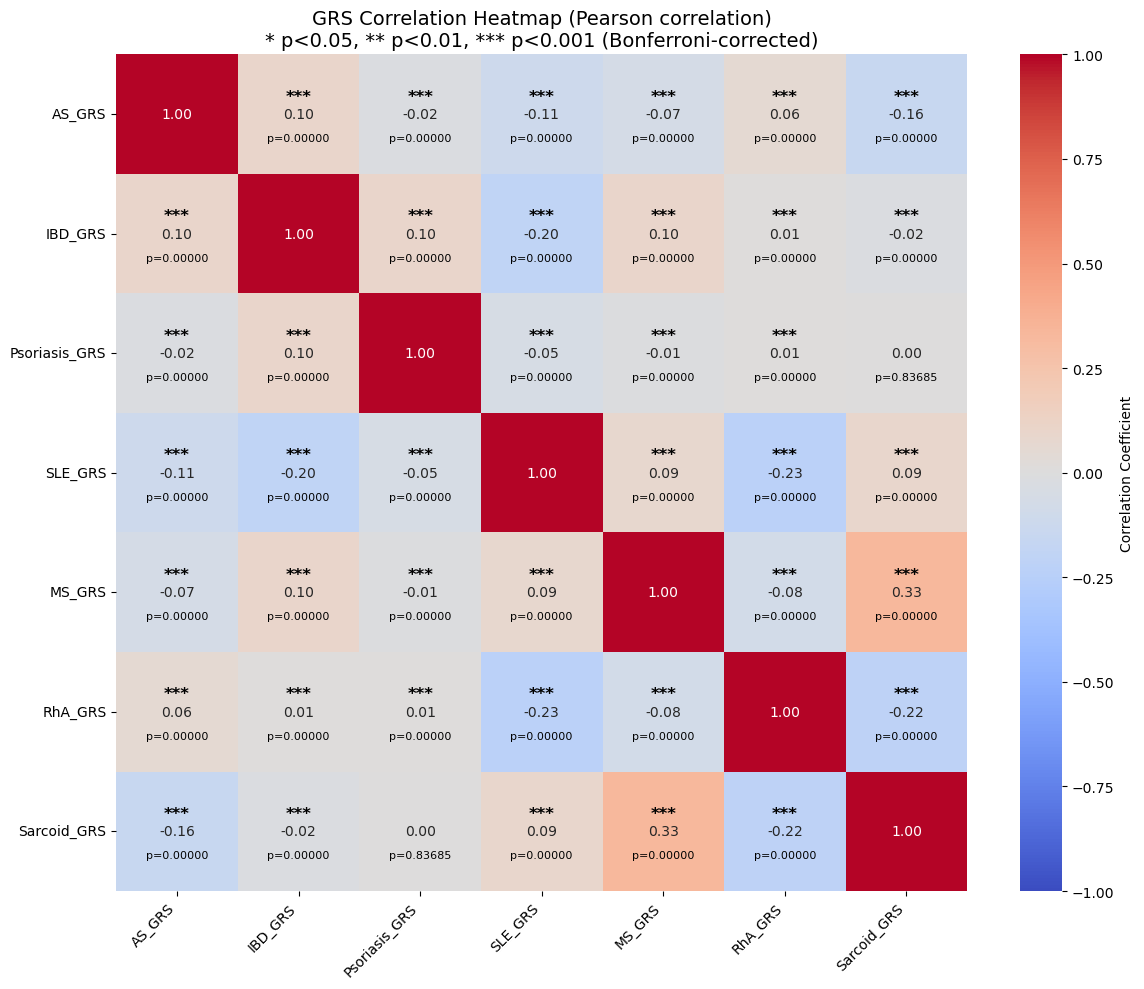


Correlation Matrix:
               AS_GRS  IBD_GRS  Psoriasis_GRS  SLE_GRS  MS_GRS  RhA_GRS  \
AS_GRS           1.00     0.10          -0.02    -0.11   -0.07     0.06   
IBD_GRS          0.10     1.00           0.10    -0.20    0.10     0.01   
Psoriasis_GRS   -0.02     0.10           1.00    -0.05   -0.01     0.01   
SLE_GRS         -0.11    -0.20          -0.05     1.00    0.09    -0.23   
MS_GRS          -0.07     0.10          -0.01     0.09    1.00    -0.08   
RhA_GRS          0.06     0.01           0.01    -0.23   -0.08     1.00   
Sarcoid_GRS     -0.16    -0.02           0.00     0.09    0.33    -0.22   

               Sarcoid_GRS  
AS_GRS               -0.16  
IBD_GRS              -0.02  
Psoriasis_GRS         0.00  
SLE_GRS               0.09  
MS_GRS                0.33  
RhA_GRS              -0.22  
Sarcoid_GRS           1.00  

Bonferroni-adjusted P-values:
               AS_GRS  IBD_GRS  Psoriasis_GRS  SLE_GRS  MS_GRS  RhA_GRS  \
AS_GRS            0.0      0.0        0.

In [22]:
plot_grs_correlation_heatmap(data, grs_list, method='pearson', uveitis=False)

### Calculating follow-up length average, and uve to condition duration

In [55]:
# Describing duration to event 

duration_list = ["uve_to_IBD_years" if 'Crohns' in i or 'UC' in i
                 else f"uve_to_{i.strip('_any')}_years" for i in disease_list]

event_list = [f"first_uve_{i.strip('_any')}" for i in disease_list]

for event, dur in zip(event_list, duration_list):
    
    temp = data.loc[data[event]==1, dur].describe()
    
    print(f"{event.strip('first_uve_')} "
          + f"{temp['50%']:.1f} years "
          +f"({temp['25%']:.1f}–{temp['75%']:.1f}, n={temp['count']:.0f})")

AS 5.1 years (1.8–9.9, n=83)
Crohn 11.6 years (3.0–16.0, n=30)
UC 10.2 years (2.0–20.1, n=21)
Psoria 10.0 years (2.6–21.0, n=79)
SLE 5.2 years (2.8–10.6, n=3)
MS 8.8 years (3.5–18.2, n=24)
RA 7.2 years (3.4–16.3, n=65)
Sarcoid 2.0 years (0.7–5.3, n=47)


In [54]:
# Describing follow-up time 
data.loc[((data['uve_to_SLE_years'].isna()==False) & (data.SLE_any!=1)), 'uve_to_SLE_years'].describe()

count    3549.000000
mean       18.872711
std        12.387134
min         0.166667
25%         9.416667
50%        16.333334
75%        25.750000
max        68.583336
Name: uve_to_SLE_years, dtype: float64

In [ ]:
plot_grs_pair(data,'Psoriasis_GRS','MS_GRS', disease1='Psoriasis_any',disease2 = 'MS_any',
         a2=0.8, filter_col='uve_any', uveitis=True)

In [ ]:
data.loc[data['first_Psoriasis']!=1, 'first_Psoriasis'] = 0
plot_grs(data,'Psoriasis_GRS','MS_GRS', disease1='Psoriasis_any',disease2 = 'MS_any',
         a2=0.8, filter_col='uve_any', uveitis=True, additional_filter={'first_Psoriasis':0, 'first_MS':0})

In [ ]:
plot_grs(data,'RhA_GRS','MS_GRS', disease1='RA_any',disease2 = 'MS_any',
         a2=0.8, filter_col='uve_any', uveitis=True)

In [ ]:
plot_grs(data,'MS_GRS','IBD_GRS', disease2='IBD_any',disease1 = 'MS_any',
         a2=0.8, filter_col='uve_any', uveitis=True)

In [ ]:
plot_grs(data,'IBD_GRS','AS_GRS', disease1='IBD_any',disease2 = 'AS_any',
         a2=0.8, filter_col='uve_any', uveitis=True)

In [ ]:
plot_grs(data,'IBD_GRS','AS_GRS', disease1='Crohns_any',disease2 = 'AS_any',
         a2=0.8, filter_col='uve_any', uveitis=True)

In [ ]:
plot_grs(data,'IBD_GRS','AS_GRS', disease1='UC_any',disease2 = 'AS_any',
         a2=0.8, filter_col='uve_any', uveitis=True)

In [ ]:
plot_grs(data,'IBD_GRS','AS_GRS', disease1='UC_any',
         disease2 = 'AS_any',
         a2=0.8, filter_col='uve_any',
         uveitis=True,additional_filter={'first_IBD':0, 'Crohns_any':0} )

In [ ]:
plot_grs(data,'IBD_GRS','AS_GRS', disease1='Crohns_any',
         disease2 = 'AS_any',
         a2=0.8, filter_col='uve_any',
         uveitis=True,additional_filter={'first_IBD':0, 'UC_any':0} )

In [ ]:
plot_grs(data,'MS_GRS','IBD_GRS', disease2='IBD_any',disease1 = 'MS_any',
         a2=0.9, filter_col='uve_any',uveitis=True, additional_filter={'first_IBD':0})

In [ ]:
plot_grs(data,'MS_GRS','IBD_GRS', disease2='UC_any',disease1 = 'MS_any',
         a2=0.9, filter_col='uve_any',uveitis=True,
         additional_filter={'first_IBD':0, 'first_MS':0, 'Crohns_any':0,'first_AS':0})

In [ ]:
plot_grs(data,'MS_GRS','AS_GRS', disease2='AS_any',disease1 = 'MS_any',
         a2=0.9, filter_col='uve_any',uveitis=True,
         additional_filter={'first_IBD':0, 'first_MS':0, 'Crohns_any':0,'first_AS':0})

In [ ]:
plot_grs(data,'MS_GRS','SLE_GRS', disease2='SLE_any',disease1 = 'MS_any',
         a2=0.9, filter_col='uve_any',uveitis=True,
         additional_filter={'first_IBD':0, 'first_MS':0, 'Crohns_any':0,'first_AS':0})